# TPS 12/21 - Feature Engineering

In this notebook we test out some feature engineering techniques using XGBoost with default settings to see if we get any improvement over the baseline.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 6

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif

# Models
from sklearn.utils.extmath import softmax
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Save data as .feather format
original = pd.read_feather('../data/original.feather')
train = pd.read_feather('../data/train.feather')

In [4]:
# Drop un-useful
train.drop(["Soil_Type7", "Id", "Soil_Type15"], axis=1, inplace=True)
train = train[train.Cover_Type != 5]

In [5]:
# Split synthetic data
train, test = train_test_split(train, test_size = 1000000, random_state = RANDOM_SEED)
features = [x for x in train.columns if x not in ['Id','Cover_Type']]

gc.collect()

# Label Encoding
new_encoder = LabelEncoder()
train["Cover_Type"] = new_encoder.fit_transform(train["Cover_Type"])
test["Cover_Type"] = new_encoder.transform(test["Cover_Type"])

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for scores
new_cols, new_cv, new_test = list(), list(), list()
old_cols, old_cv = list(), list()

print(f'\nOriginal Train Size: {original.shape[0]} rows, {original.shape[1]} cols')
print(f'Synthetic Train Size: {train.shape[0]} rows, {train.shape[1]} cols')
print(f'Synthetic Test Size: {test.shape[0]} rows, {test.shape[1]} cols\n')


Original Train Size: 581012 rows, 55 cols
Synthetic Train Size: 2999999 rows, 53 cols
Synthetic Test Size: 1000000 rows, 53 cols



# Scoring Functions

In [6]:
# Scoring/Training Baseline Function
def score_newdata(processing = None):
    
    print('Data: TPS 12/21 (Synthetic)')
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], len(train.Cover_Type.value_counts())))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = train[features].iloc[train_idx]
        X_valid = train[features].iloc[valid_idx]
        X_test = test[features]
        
        # Feature Engineering
        if processing:
            X_train = processing(X_train)
            X_valid = processing(X_valid)
            X_test = processing(X_test)
        
        # Training and Target Labels
        y_train = train['Cover_Type'].iloc[train_idx]
        y_valid = train['Cover_Type'].iloc[valid_idx]
        y_test = test['Cover_Type']
        
        gc.collect()
        
        # Create model
        model = XGBClassifier(
            booster = 'gbtree',
            tree_method = 'hist',
            eval_metric = 'mlogloss',
            random_state = RANDOM_SEED,
        )
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    test_preds = np.argmax(test_preds, axis = 1)
    holdout_score = accuracy_score(y_test, test_preds)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('\nHoldout Accuracy:', holdout_score)
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(y_test, test_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    return scores.mean(), holdout_score

In [7]:
# Scoring/Training Baseline Function
def score_olddata(processing = None):
    
    print('Data: Forest Covtype (Original)')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(original, original['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = original[features].iloc[train_idx]
        X_valid = original[features].iloc[valid_idx]
        
        # Feature Engineering
        if processing:
            X_train = processing(X_train)
            X_valid = processing(X_valid)
        
        # Training and Target Labels
        y_train = original['Cover_Type'].iloc[train_idx]
        y_valid = original['Cover_Type'].iloc[valid_idx]
        
        gc.collect()
        
        # Create model
        model = XGBClassifier(
            booster = 'gbtree',
            tree_method = 'hist',
            eval_metric = 'mlogloss',
            random_state = RANDOM_SEED,
        )
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy:  {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    print("Worst Accuracy:", round(scores.min(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(original['Cover_Type'], oof_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    return scores.mean()

# XGBoost Baseline

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95875 in 70.11s.
Fold 1 Accuracy: 0.95847 in 76.06s.
Fold 2 Accuracy: 0.95876 in 75.43s.
Fold 3 Accuracy: 0.95914 in 76.39s.
Fold 4 Accuracy: 0.95922 in 76.15s.
Fold 5 Accuracy: 0.95903 in 76.16s.

Average CV Accuracy: 0.95889
Worst CV Accuracy: 0.95847

Holdout Accuracy: 0.959299
Training Time: 450.3s



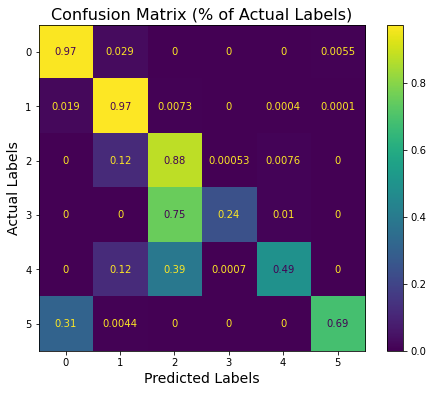

In [8]:
new_cols.append('Baseline')
cv_score, test_score = score_newdata()
new_cv.append(cv_score)
new_test.append(test_score)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87248 in 12.96s.
Fold 1 Accuracy:  0.87105 in 13.57s.
Fold 2 Accuracy:  0.86824 in 14.46s.
Fold 3 Accuracy:  0.8701 in 12.89s.
Fold 4 Accuracy:  0.86874 in 12.88s.
Fold 5 Accuracy:  0.86912 in 12.76s.

Average Accuracy: 0.86995
Worst Accuracy: 0.86824
Training Time: 79.52s



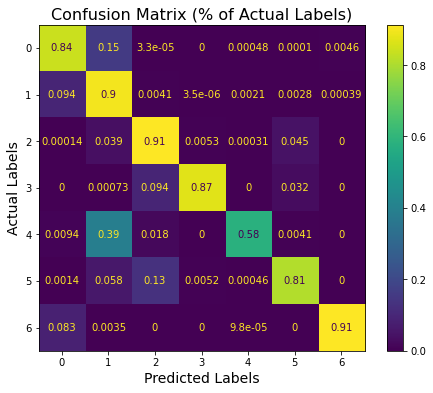

In [9]:
old_cols.append('Baseline')
cv_score = score_olddata()
old_cv.append(cv_score)

# Feature Engineering

These function perform various feature cleaning and engineering tasks

## 1. Fix Aspect Range

In [10]:
# Fix aspect
def fix_aspect(data):
    
    df = data.copy()
    
    df["Aspect"][df["Aspect"] < 0] += 360
    df["Aspect"][df["Aspect"] > 359] -= 360
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95873 in 71.37s.
Fold 1 Accuracy: 0.95857 in 72.48s.
Fold 2 Accuracy: 0.95872 in 74.67s.
Fold 3 Accuracy: 0.95915 in 72.56s.
Fold 4 Accuracy: 0.95922 in 74.7s.
Fold 5 Accuracy: 0.95899 in 72.8s.

Average CV Accuracy: 0.9589
Worst CV Accuracy: 0.95857

Holdout Accuracy: 0.959286
Training Time: 438.58s



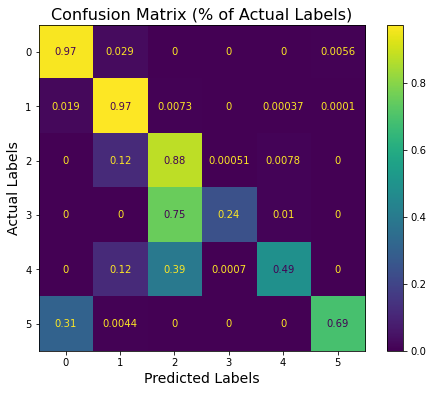

In [11]:
new_cols.append('Fix_Aspect')
cv_score, test_score = score_newdata(fix_aspect)
new_cv.append(cv_score)
new_test.append(test_score)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.8703 in 13.37s.
Fold 1 Accuracy:  0.87143 in 13.04s.
Fold 2 Accuracy:  0.8719 in 12.81s.
Fold 3 Accuracy:  0.87076 in 12.88s.
Fold 4 Accuracy:  0.87277 in 13.15s.
Fold 5 Accuracy:  0.87 in 12.98s.

Average Accuracy: 0.87119
Worst Accuracy: 0.87
Training Time: 78.23s



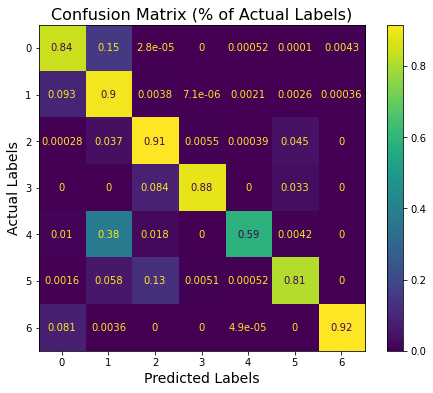

In [12]:
old_cols.append('Fix_Aspect')
cv_score = score_olddata(fix_aspect)
old_cv.append(cv_score)

## 2. Fix Hillshade Range

In [13]:
# Fix Hillshade
def fix_hillshade(data):
    
    df = data.copy()
    
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95876 in 69.98s.
Fold 1 Accuracy: 0.95867 in 73.69s.
Fold 2 Accuracy: 0.9586 in 72.6s.
Fold 3 Accuracy: 0.95909 in 72.27s.
Fold 4 Accuracy: 0.9592 in 72.66s.
Fold 5 Accuracy: 0.95908 in 72.24s.

Average CV Accuracy: 0.9589
Worst CV Accuracy: 0.9586

Holdout Accuracy: 0.959231
Training Time: 433.44s



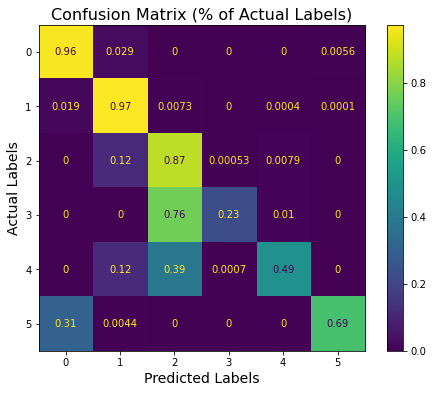

In [14]:
new_cols.append('Fix_Hillshade')
cv_score, test_score = score_newdata(fix_hillshade)
new_cv.append(cv_score)
new_test.append(test_score)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87248 in 12.81s.
Fold 1 Accuracy:  0.87105 in 13.05s.
Fold 2 Accuracy:  0.86824 in 12.88s.
Fold 3 Accuracy:  0.8701 in 12.89s.
Fold 4 Accuracy:  0.86874 in 12.87s.
Fold 5 Accuracy:  0.86912 in 12.86s.

Average Accuracy: 0.86995
Worst Accuracy: 0.86824
Training Time: 77.35s



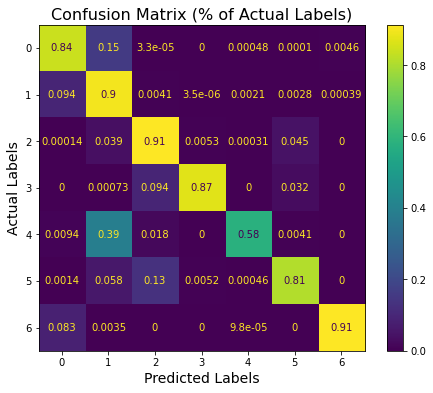

In [15]:
old_cols.append('Fix_Hillshade')
cv_score = score_olddata(fix_hillshade)
old_cv.append(cv_score)

## 3. Water Distance Features

In [16]:
# Distance to Water
def water_distance_features(data):
    
    df = data.copy()
    
    # Taxicab Distance 
    df["Hydro_Taxicab"] = np.abs(df["Horizontal_Distance_To_Hydrology"]) + np.abs(df["Vertical_Distance_To_Hydrology"])

    # Euclidean distance to Hydrology
    df["Hydro_Euclid"] = (df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95865 in 98.81s.
Fold 1 Accuracy: 0.95847 in 100.19s.
Fold 2 Accuracy: 0.95867 in 95.91s.
Fold 3 Accuracy: 0.95893 in 95.28s.
Fold 4 Accuracy: 0.95907 in 97.52s.
Fold 5 Accuracy: 0.95919 in 98.77s.

Average CV Accuracy: 0.95883
Worst CV Accuracy: 0.95847

Holdout Accuracy: 0.959186
Training Time: 586.48s



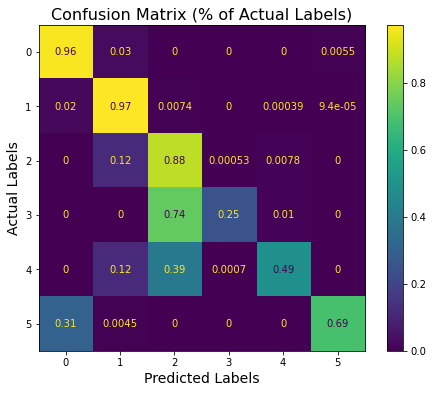

In [17]:
new_cols.append('Water_Dist')
cv_score, test_score = score_newdata(water_distance_features)
new_cv.append(cv_score)
new_test.append(test_score)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.86977 in 18.46s.
Fold 1 Accuracy:  0.87064 in 18.92s.
Fold 2 Accuracy:  0.87132 in 18.56s.
Fold 3 Accuracy:  0.87028 in 18.63s.
Fold 4 Accuracy:  0.86982 in 18.94s.
Fold 5 Accuracy:  0.87318 in 18.52s.

Average Accuracy: 0.87083
Worst Accuracy: 0.86977
Training Time: 112.04s



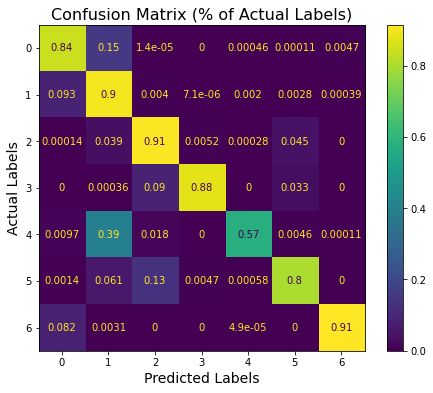

In [18]:
old_cols.append('Water_Dist')
cv_score = score_olddata(water_distance_features)
old_cv.append(cv_score)

## 4. Count Features

In [19]:
# Create count features
def count_features(data):
    
    df = data.copy()
    soil_features = [x for x in df.columns if x.startswith("Soil_Type")]
    wilderness_features = [x for x in df.columns if x.startswith("Wilderness_Area")]

    # Count features
    df["Soil_Count"] = df[soil_features].apply(sum, axis=1)
    df["Wilderness_Count"] = df[wilderness_features].apply(sum, axis=1)
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.96068 in 78.35s.
Fold 1 Accuracy: 0.96048 in 77.97s.
Fold 2 Accuracy: 0.96072 in 78.46s.
Fold 3 Accuracy: 0.96085 in 77.25s.
Fold 4 Accuracy: 0.96087 in 77.43s.
Fold 5 Accuracy: 0.96089 in 77.26s.

Average CV Accuracy: 0.96075
Worst CV Accuracy: 0.96048

Holdout Accuracy: 0.961435
Training Time: 466.72s



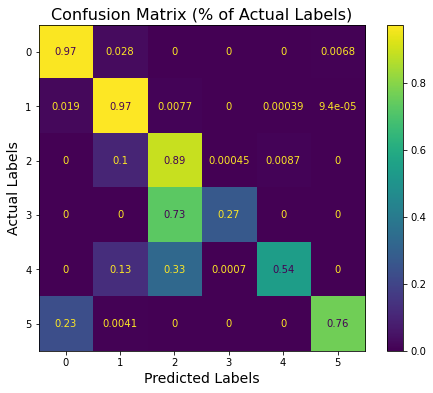

In [20]:
new_cols.append('Count')
cv_score, test_score = score_newdata(count_features)
new_cv.append(cv_score)
new_test.append(test_score)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87176 in 13.13s.
Fold 1 Accuracy:  0.86844 in 13.05s.
Fold 2 Accuracy:  0.86851 in 12.98s.
Fold 3 Accuracy:  0.86817 in 12.91s.
Fold 4 Accuracy:  0.86888 in 12.98s.
Fold 5 Accuracy:  0.87122 in 13.19s.

Average Accuracy: 0.8695
Worst Accuracy: 0.86817
Training Time: 78.23s



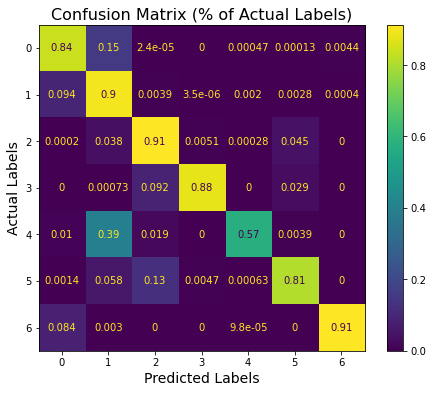

In [21]:
old_cols.append('Count')
cv_score = score_olddata(count_features)
old_cv.append(cv_score)

## 5. Shade Features

In [22]:
# Create Shade features
def new_shade_features(data):
    
    df = data.copy()
    shade_features = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

    # Hillshade
    df["Hillshade_Avg"] = df[shade_features].mean(axis=1)
    df['Hillshade_Range'] = df[shade_features].max(axis=1) - df[shade_features].min(axis=1)
    
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95863 in 74.11s.
Fold 1 Accuracy: 0.95862 in 74.48s.
Fold 2 Accuracy: 0.95873 in 74.96s.
Fold 3 Accuracy: 0.95912 in 75.07s.
Fold 4 Accuracy: 0.95916 in 74.47s.
Fold 5 Accuracy: 0.95894 in 77.1s.

Average CV Accuracy: 0.95887
Worst CV Accuracy: 0.95862

Holdout Accuracy: 0.959283
Training Time: 450.2s



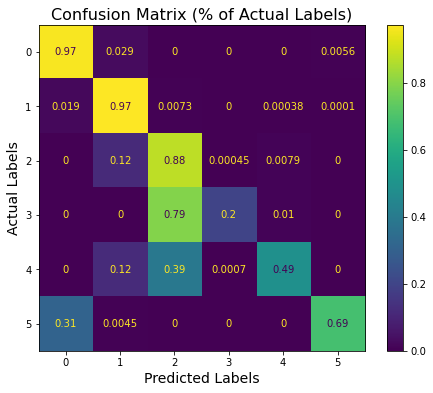

In [23]:
new_cols.append('Shade_Features')
cv_score, test_score = score_newdata(new_shade_features)
new_cv.append(cv_score)
new_test.append(test_score)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87 in 13.45s.
Fold 1 Accuracy:  0.87042 in 13.87s.
Fold 2 Accuracy:  0.87185 in 13.55s.
Fold 3 Accuracy:  0.87034 in 13.56s.
Fold 4 Accuracy:  0.87121 in 13.33s.
Fold 5 Accuracy:  0.87011 in 13.36s.

Average Accuracy: 0.87065
Worst Accuracy: 0.87
Training Time: 81.12s



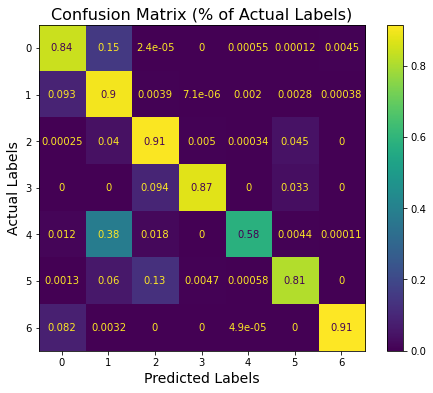

In [24]:
old_cols.append('Shade_Features')
cv_score = score_olddata(new_shade_features)
old_cv.append(cv_score)

## 6. Distance Interaction Features

In [25]:
def distance_interactions(data):
    
    df = data.copy()
    df['Hydro_Fire_1'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])
    df['Hydro_Road_1'] = abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])
    df['Hydro_Road_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_1'] = abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_2'] = abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95938 in 77.56s.
Fold 1 Accuracy: 0.95921 in 79.09s.
Fold 2 Accuracy: 0.95925 in 82.98s.
Fold 3 Accuracy: 0.9596 in 79.82s.
Fold 4 Accuracy: 0.9595 in 85.26s.
Fold 5 Accuracy: 0.95972 in 81.39s.

Average CV Accuracy: 0.95944
Worst CV Accuracy: 0.95921

Holdout Accuracy: 0.959903
Training Time: 486.1s



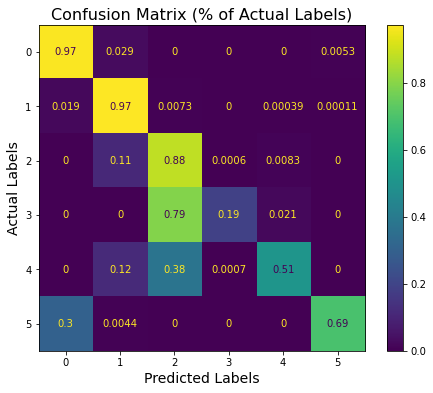

In [26]:
new_cols.append('Dist_Interactions')
cv_score, test_score = score_newdata(distance_interactions)
new_cv.append(cv_score)
new_test.append(test_score)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.89198 in 14.64s.
Fold 1 Accuracy:  0.89037 in 14.48s.
Fold 2 Accuracy:  0.89037 in 14.49s.
Fold 3 Accuracy:  0.88913 in 14.49s.
Fold 4 Accuracy:  0.89142 in 14.88s.
Fold 5 Accuracy:  0.88914 in 14.46s.

Average Accuracy: 0.8904
Worst Accuracy: 0.88913
Training Time: 87.45s



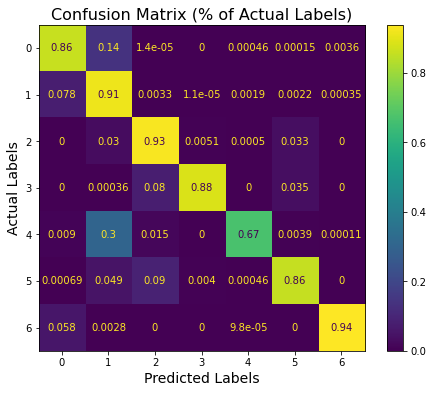

In [27]:
old_cols.append('Dist_Interactions')
cv_score = score_olddata(distance_interactions)
old_cv.append(cv_score)

## 7. Misc. Interaction Features

In [28]:
def various_interactions(data):
    
    df = data.copy()
    df['EHiElv'] = df['Horizontal_Distance_To_Roadways'] * df['Elevation']
    df['EViElv'] = df['Vertical_Distance_To_Hydrology'] * df['Elevation']
    df['Highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)
    df['EVDtH'] = df.Elevation - df.Vertical_Distance_To_Hydrology
    df['EHDtH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
    df['Hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)
    return df

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95942 in 81.97s.
Fold 1 Accuracy: 0.95922 in 81.7s.
Fold 2 Accuracy: 0.95934 in 82.02s.
Fold 3 Accuracy: 0.95994 in 80.66s.
Fold 4 Accuracy: 0.95995 in 81.98s.
Fold 5 Accuracy: 0.95962 in 80.94s.

Average CV Accuracy: 0.95958
Worst CV Accuracy: 0.95922

Holdout Accuracy: 0.960048
Training Time: 489.27s



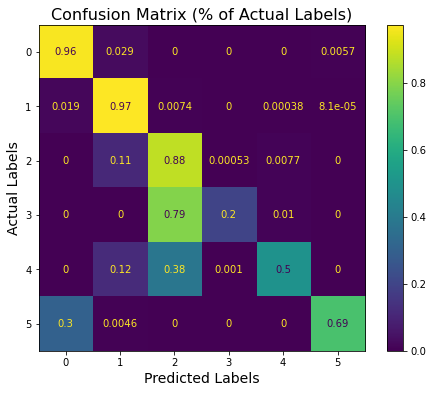

In [29]:
new_cols.append('Various_Interactions')
cv_score, test_score = score_newdata(various_interactions)
new_cv.append(cv_score)
new_test.append(test_score)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.88203 in 14.16s.
Fold 1 Accuracy:  0.87833 in 14.49s.
Fold 2 Accuracy:  0.87941 in 14.03s.
Fold 3 Accuracy:  0.88196 in 14.05s.
Fold 4 Accuracy:  0.88257 in 13.98s.
Fold 5 Accuracy:  0.88035 in 14.79s.

Average Accuracy: 0.88078
Worst Accuracy: 0.87833
Training Time: 85.5s



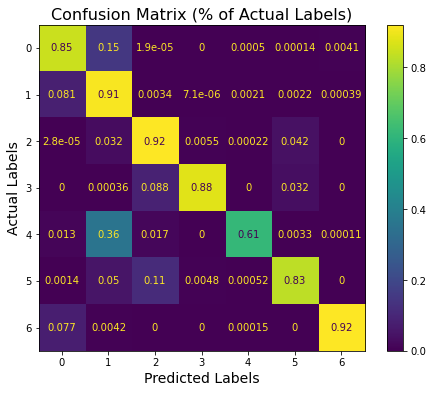

In [30]:
old_cols.append('Various_Interactions')
cv_score = score_olddata(various_interactions)
old_cv.append(cv_score)

# Summary

In [33]:
pd.DataFrame(data = dict(
    features = new_cols,
    cv_scores = new_cv,
    holdout = new_test
)).sort_values('holdout')

,features,cv_scores,holdout
3,Water_Dist,0.958831,0.959186
2,Fix_Hillshade,0.958901,0.959231
5,Shade_Features,0.958867,0.959283
1,Fix_Aspect,0.958898,0.959286
0,Baseline,0.958894,0.959299
6,Dist_Interactions,0.959443,0.959903
7,Various_Interactions,0.959582,0.960048
4,Count,0.960748,0.961435


In [34]:
pd.DataFrame(data = dict(
    features = old_cols,
    cv_scores = old_cv,
)).sort_values('cv_scores')

,features,cv_scores
4,Count,0.869497
0,Baseline,0.869953
2,Fix_Hillshade,0.869953
5,Shade_Features,0.870655
3,Water_Dist,0.870834
1,Fix_Aspect,0.871192
7,Various_Interactions,0.880777
6,Dist_Interactions,0.890403


# Soil Type Features

Next, were going to attempt to leverage domain knowledge to derive further categorical features using the soil types. From the description of the dataset, we have the following:
```
     ID    Code	    Description
     
	 1	   2702		Cathedral family - Rock outcrop complex, extremely stony.
	 2	   2703		Vanet - Ratake families complex, very stony.
	 3	   2704		Haploborolis - Rock outcrop complex, rubbly.
	 4	   2705		Ratake family - Rock outcrop complex, rubbly.
	 5	   2706		Vanet family - Rock outcrop complex complex, rubbly.
	 6	   2717		Vanet - Wetmore families - Rock outcrop complex, stony.
	 7	   3501		Gothic family.
	 8	   3502		Supervisor - Limber families complex.
	 9	   4201		Troutville family, very stony.
	10	   4703		Bullwark - Catamount families - Rock outcrop complex, rubbly.
	11	   4704		Bullwark - Catamount families - Rock land complex, rubbly.
	12	   4744		Legault family - Rock land complex, stony.
	13	   4758		Catamount family - Rock land - Bullwark family complex, rubbly.
	14	   5101		Pachic Argiborolis - Aquolis complex.
	15	   5151		unspecified in the USFS Soil and ELU Survey.
	16	   6101		Cryaquolis - Cryoborolis complex.
	17	   6102		Gateview family - Cryaquolis complex.
	18	   6731		Rogert family, very stony.
	19	   7101		Typic Cryaquolis - Borohemists complex.
	20	   7102		Typic Cryaquepts - Typic Cryaquolls complex.
	21	   7103		Typic Cryaquolls - Leighcan family, till substratum complex.
	22	   7201		Leighcan family, till substratum, extremely bouldery.
	23	   7202		Leighcan family, till substratum - Typic Cryaquolls complex.
	24	   7700		Leighcan family, extremely stony.
	25	   7701		Leighcan family, warm, extremely stony.
	26	   7702		Granile - Catamount families complex, very stony.
	27	   7709		Leighcan family, warm - Rock outcrop complex, extremely stony.
	28	   7710		Leighcan family - Rock outcrop complex, extremely stony.
	29	   7745		Como - Legault families complex, extremely stony.
	30	   7746		Como family - Rock land - Legault family complex, extremely stony.
	31	   7755		Leighcan - Catamount families complex, extremely stony.
	32	   7756		Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
	33	   7757		Leighcan - Catamount families - Rock outcrop complex, extremely stony.
	34	   7790		Cryorthents - Rock land complex, extremely stony.
	35	   8703		Cryumbrepts - Rock outcrop - Cryaquepts complex.
	36	   8707		Bross family - Rock land - Cryumbrepts complex, extremely stony.
	37	   8708		Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
	38	   8771		Leighcan - Moran families - Cryaquolls complex, extremely stony.
	39	   8772		Moran family - Cryorthents - Leighcan family complex, extremely stony.
	40	   8776		Moran family - Cryorthents - Rock land complex, extremely stony.
    
        Note:   First digit:  climatic zone             Second digit:  geologic zones
                1.  lower montane dry                   1.  alluvium
                2.  lower montane                       2.  glacial
                3.  montane dry                         3.  shale
                4.  montane                             4.  sandstone
                5.  montane dry and montane             5.  mixed sedimentary
                6.  montane and subalpine               6.  unspecified in the USFS ELU Survey
                7.  subalpine                           7.  igneous and metamorphic
                8.  alpine                              8.  volcanic

        The third and fourth ELU digits are unique to the mapping unit 
        and have no special meaning to the climatic or geologic zones.
```

## 1. Climatic Zone (Ordinal)

1.  lower montane dry                   
2.  lower montane                       
3.  montane dry                         
4.  montane                             
5.  montane dry and montane             
6.  montane and subalpine               
7.  subalpine                           
8.  alpine                              

## 2. Geologic Zone (Nominal)

1.  alluvium
2.  glacial
3.  shale
4.  sandstone
5.  mixed sedimentary
6.  unspecified in the USFS ELU Survey
7.  igneous and metamorphic
8.  volcanic

## 3. Surface Cover by Stones/Boulders (Ordinal)

According to the [USDA reference](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/ref/?cid=nrcs142p2_054253#surface_fragments) on soil profiling:

1. **(Stony/Bouldery)** — Stones or boulders cover 0.01 to less than 0.1 percent of the surface. The smallest stones are at least 8 meters apart; the smallest boulders are at least 20 meters apart (fig. 3-9).

2. **(Very Stony/Very Bouldery)** — Stones or boulders cover 0.1 to less than 3 percent of the surface. The smallest stones are not less than 1 meter apart; the smallest boulders are not less than 3 meters apart (fig. 3-10).

3. **(Extremely Stony/Extremely Bouldery)** — Stones or boulders cover 3 to less than 15 percent of the surface. The smallest stones are as little as 0.5 meter apart; the smallest boulders are as little as 1 meter apart (fig. 3-11).

4. **(Rubbly)** — Stones or boulders cover 15 to less than 50 percent of the surface. The smallest stones are as little as 0.3 meter apart; the smallest boulders are as little as 0.5 meter apart. In most places it is possible to step from stone to stone or jump from boulder to boulder without touching the soil (fig. 3-12).

5. **(Very Rubbly)** — Stones or boulders appear to be nearly continuous and cover 50 percent or more of the surface. The smallest stones are less than 0.03 meter apart; the smallest boulders are less than 0.05 meter apart. Classifiable soil is among the rock fragments, and plant growth is possible (fig. 3-13).

## 4. Rock Size (Ordinal)

According to the [USDA reference](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/ref/?cid=nrcs142p2_054253#fragments) on soil profile:

* Stones/Stony - 250–600 mm diameter
* Boulders/Bouldery - > 600 mm diameter

We can use these to perhaps derive useful features

## 5. Family (Nominal)

Group soil features on whether or not they belong to certain descriptions. Will one-hot encorde most likely